# Intro

This is an attempt to learn TensorFlow2 to predict time series data. This note book is a comparision between LSTM and GRU in default parameter just to compare the accuracy of the models.

I use this Youtube vdo https://www.youtube.com/watch?v=c0k-YLQGKjY as a concept. However, the code and interpretations are all my writing.

In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error as mse 


In [2]:
# prepare the data
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True
)
csv_path, _ = os.path.splitext(zip_path)

In [3]:
df = pd.read_csv(csv_path)
df = df[5::6]

df.head(4)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0


The data has 10 minute interval which are too small of a change. Let's extract an hour by hour data by using (start:stop:step) slicing. Beginning with line 5 and each 6 line since they are the beginning of an hour.

In [4]:

df.index = pd.to_datetime(df['Date Time'],format='%d.%m.%Y %H:%M:%S') #set and format datetime index

df.head(3)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,,
2009-01-01 01:00:00,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 02:00:00,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2009-01-01 03:00:00,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2


I would like to train a model using LSTM and GRU to predict the temperature(T (degC)) and pressure(p (mbar)). Let's plot them up, perhaps there are some interesting patterns.

<AxesSubplot:xlabel='Date Time'>

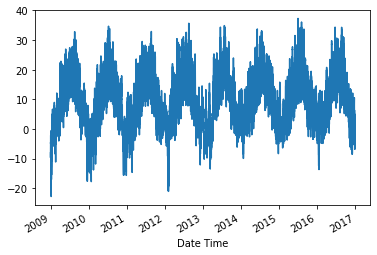

In [5]:
temp = df['T (degC)']
temp.plot()

<AxesSubplot:xlabel='Date Time'>

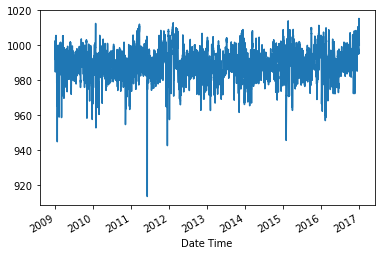

In [6]:
p = df['p (mbar)']
p.plot(mark_right=True)

Temperature is highly cyclical while the peressure cycle is less prominent.

### Preparation of inputs

Although I can use features as much as I'd like, considering the computational expeses, I will stick with the lag features (targets lag) and time features (cyclical timestamp.)

Noted for the cyclical timestamp is that the temperature and pressure behave in cyclical manner throughout the entire time span no matter how long the time duration is. Thus there should be some kind of 'cycle time description' instead of the linear time stamp we usually use since the linear time stamp will just keep increasing linearly.

This lead us to the sin and cos of the time data.

First let's transform timestamp to continuous seconds and tranform the seconds in to the sin and cos later.

In [7]:
p_temp_df = df.loc[:,['p (mbar)','T (degC)']]
p_temp_df['sec'] = p_temp_df.index.map(pd.Timestamp.timestamp)

p_temp_df.head(3)

,p (mbar),T (degC),sec
Date Time,,,
2009-01-01 01:00:00,996.50,-8.05,1.230772e+09
2009-01-01 02:00:00,996.62,-8.88,1.230775e+09
2009-01-01 03:00:00,996.84,-8.81,1.230779e+09


In [8]:
seconds_in_day = 60*60*24
seconds_in_year = 364.2425 * seconds_in_day

p_temp_df['day_sin'] = np.sin((p_temp_df['sec'])/seconds_in_day)
p_temp_df['day_cos'] = np.cos((p_temp_df['sec'])/seconds_in_day)

p_temp_df['year_sin'] = np.sin((p_temp_df['sec'])/seconds_in_year)
p_temp_df['year_cos'] = np.cos((p_temp_df['sec'])/seconds_in_year)

p_temp_df.drop('sec',axis=1, inplace=True)

p_temp_df.head(2)

,p (mbar),T (degC),day_sin,day_cos,year_sin,year_cos
Date Time,,,,,,
2009-01-01 01:00:00,996.50,-8.05,0.872637,0.488370,0.987030,0.160535
2009-01-01 02:00:00,996.62,-8.88,0.892222,0.451597,0.987048,0.160422


The features seem to be ready let's define some helper function to preprocess the inputs.

In [9]:
#split X and y by the window size. The window size is actually the interval the model are iterating through just like the rolling window.

def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        target = df_as_np[i+window_size][0], df_as_np[i+window_size][1] #now the target are pressure and temperature
        y.append(target)
     
    return np.array(X), np.array(y)

In [10]:
#Standard scaler for multi targets

def double_target_s_scaler(array):
    mean1 = np.mean(array[:,:,0]) #mean of only the pressure column
    std1 = np.std(array[:,:,0]) #std of only the pressure column
    mean2 = np.mean(array[:,:,1]) #mean of only the temperature column
    std2 = np.std(array[:,:,1]) #std of only the temperature column
    
    array[:,:,0] = (array[:,:,0]-mean1)/std1 # minus the mean and divided by the std to scale the data
    array[:,:,1] = (array[:,:,1]-mean2)/std2 # minus the mean and divided by the std to scale the data
    
    return array #return the scaled data

In [11]:
# function to slice the data into train/test/val

def tvt_slice(X,y,train_period,val_period):
    X_train, y_train = X[:train_period], y[:train_period]
    X_val, y_val = X[train_period:val_period], y[train_period:val_period]
    X_test, y_test = X[val_period:], y[val_period:]
    
    return X_train,y_train,X_val,y_val,X_test,y_test

In [12]:
X_all, y_all = df_to_X_y(p_temp_df,window_size=7) #rolling window of 7 periods per window

In [13]:
X_all.shape, y_all.shape

((70084, 7, 6), (70084, 2))

There are 70084 windows for our models to train on. Let's split them into 60000 training 5000 validation and the rest (5084) to be testing.

In [14]:
X_all = double_target_s_scaler(X_all)

In [15]:
X_train,y_train,X_val,y_val,X_test,y_test = tvt_slice(X_all,y_all,60000,65000)

X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape

((60000, 7, 6), (60000, 2), (5000, 7, 6), (5000, 2), (5084, 7, 6), (5084, 2))

Now we have train/val/test ready, Let's try to create a function that would compare many models at once.

First we need to prepare the models. I will use LSTM and GRU for this comparision. All the model will use the default hyperparameters for simplicity.

In [16]:
from tensorflow.keras.models import Sequential # to make a sequential model
from tensorflow.keras.layers import * # the sequences used in the model
from tensorflow.keras.callbacks import ModelCheckpoint # to save the model state
from tensorflow.keras.losses import MeanSquaredError # loss function used
from tensorflow.keras.metrics import  RootMeanSquaredError # metrics used
from tensorflow.keras.optimizers import Adam #ADAM stochastic gradient descent algo.

In [42]:
lstm = Sequential(name='LSTM_test')
lstm.add(InputLayer(input_shape=(7,6)))
lstm.add(LSTM(units=64)) # 64 is arbitary number
lstm.add(Dense(units=8,activation='relu')) #layer 2 of NN
lstm.add(Dense(units=2,activation='linear')) #output layer 2 for both pressure and temperature

gru = Sequential(name='GRU_Test')
gru.add(InputLayer(input_shape=(7,6)))
gru.add(GRU(units=64)) # 64 is arbitary number
gru.add(Dense(units=8,activation='relu')) #layer 2 of NN
gru.add(Dense(units=2,activation='linear')) #output layer 2 for both pressure and temperature

In [43]:
lstm.summary()

Model: "LSTM_test"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                18176     
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 18        
Total params: 18,714
Trainable params: 18,714
Non-trainable params: 0
_________________________________________________________________


In [44]:
gru.summary()

Model: "GRU_Test"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 64)                13824     
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 18        
Total params: 14,362
Trainable params: 14,362
Non-trainable params: 0
_________________________________________________________________


Two models are ready. Let's create the modelcheckpoint insatance to save the best model in training.

In [45]:
cp_lstm = ModelCheckpoint(filepath='lstm_test/',save_best_only=True)
cp_gru = ModelCheckpoint(filepath='gru_test/',save_best_only=True)

Compile the model

In [46]:
lstm.compile(optimizer=Adam(),loss=MeanSquaredError(),metrics=[RootMeanSquaredError()]) 
gru.compile(optimizer=Adam(),loss=MeanSquaredError(),metrics=[RootMeanSquaredError()]) 

Now the models are ready. Let's define a function to train and compare them togeter.

In [47]:
# a function to train and compare all the model all at once.

def models_compare(model_list,X_train,y_train,epoch,validation_data_tuple,X_test,y_test):
    df = pd.DataFrame()
    df['actual_0'] = y_test[:,[0]].flatten()
    df['actual_1'] = y_test[:,[1]].flatten()
    metric_dic = {}
                                
    for i, model in enumerate(model_list):
        cp = ModelCheckpoint(filepath='model_list_{}/'.format(i),save_best_only=True)
        
        model.fit(X_train,y_train,epochs=epoch,validation_data=validation_data_tuple,callbacks=[cp])
        pred = model.predict(X_test)     
        df['model_{}_predict_0'.format(i)] = pred[:,[0]].flatten()
        df['model_{}_predict_1'.format(i)] = pred[:,[1]].flatten()
        metric_dic['model_{}_MSE'.format(i)]= mse(y_test,pred)
                            
    return df, metric_dic

In [48]:
test_df, test_dic = models_compare(model_list=[lstm,gru],
                                   X_train=X_train,
                                   y_train=y_train,
                                   epoch=10,
                                   validation_data_tuple=(X_val,y_val),
                                   X_test=X_test,
                                   y_test=y_test)

Train on 60000 samples, validate on 5000 samples
Epoch 1/10


2022-05-08 23:07:55.373089: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_4424_4895' and '__inference___backward_standard_lstm_4424_4895_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_5003' both implement 'lstm_d1547ce3-e8a9-4c92-8163-9cb7ff59d62f' but their signatures do not match.


59968/60000 [============================>.] - ETA: 0s - loss: 203361.2924 - root_mean_squared_error: 450.9558

2022-05-08 23:08:25.828639: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_10821' and '__inference_standard_lstm_10821_specialized_for_LSTM_test_lstm_1_StatefulPartitionedCall_at___inference_distributed_function_11171' both implement 'lstm_9dfea0d6-faf8-4a40-9d21-8750d57755ac' but their signatures do not match.
2022-05-08 23:08:28.685691: W tensorflow/python/util/util.cc:299] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model_list_0/assets
60000/60000 [==============================] - 35s 587us/sample - loss: 203254.6321 - root_mean_squared_error: 450.8375 - val_loss: 3315.6628 - val_root_mean_squared_error: 57.5818
Epoch 2/10
60000/60000 [==============================] - 34s 561us/sample - loss: 312.1431 - root_mean_squared_error: 17.6676 - val_loss: 69.6890 - val_root_mean_squared_error: 8.3480
Epoch 3/10
60000/60000 [==============================] - 33s 550us/sample - loss: 70.3005 - root_mean_squared_error: 8.3845 - val_loss: 67.1231 - val_root_mean_squared_error: 8.1929
Epoch 4/10
60000/60000 [==============================] - 57s 950us/sample - loss: 50.7691 - root_mean_squared_error: 7.1252 - val_loss: 23.9979 - val_root_mean_squared_error: 4.8988
Epoch 5/10
60000/60000 [==============================] - 37s 623us/sample - loss: 37.6523 - root_mean_squared_error: 6.1361 - val_l

2022-05-08 23:14:44.917594: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_120558' and '__inference_standard_lstm_120558_specialized_for_LSTM_test_lstm_1_StatefulPartitionedCall_at___inference_distributed_function_120867' both implement 'lstm_1292365e-2378-449b-9be2-a77e5407339b' but their signatures do not match.


Train on 60000 samples, validate on 5000 samples
Epoch 1/10


2022-05-08 23:14:47.194324: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_gru_122831_123207_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_123310' and '__inference___backward_cudnn_gru_with_fallback_122586_122724' both implement 'gru_5aeeac3d-6633-40cf-863c-5b04227d54bc' but their signatures do not match.


59936/60000 [============================>.] - ETA: 0s - loss: 189728.6504 - root_mean_squared_error: 435.5788

2022-05-08 23:15:22.068834: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_gru_129131' and '__inference_standard_gru_129131_specialized_for_GRU_Test_gru_1_StatefulPartitionedCall_at___inference_distributed_function_129416' both implement 'gru_4735f701-1874-4152-8620-de9869f27c75' but their signatures do not match.


INFO:tensorflow:Assets written to: model_list_1/assets
60000/60000 [==============================] - 40s 660us/sample - loss: 189528.8137 - root_mean_squared_error: 435.3493 - val_loss: 2440.8284 - val_root_mean_squared_error: 49.4047
Epoch 2/10
60000/60000 [==============================] - 34s 563us/sample - loss: 241.2451 - root_mean_squared_error: 15.5321 - val_loss: 67.7495 - val_root_mean_squared_error: 8.2310
Epoch 3/10
60000/60000 [==============================] - 33s 549us/sample - loss: 70.3547 - root_mean_squared_error: 8.3878 - val_loss: 70.9564 - val_root_mean_squared_error: 8.4236
Epoch 4/10
60000/60000 [==============================] - 44s 731us/sample - loss: 58.4737 - root_mean_squared_error: 7.6468 - val_loss: 21.8497 - val_root_mean_squared_error: 4.6744
Epoch 5/10
60000/60000 [==============================] - 37s 620us/sample - loss: 36.6947 - root_mean_squared_error: 6.0576 - val_loss: 22.1488 - val_root_mean_squared_error: 4.7062
Epoch 6/10
60000/60000 [======

2022-05-08 23:21:06.895917: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_gru_with_fallback_226534' and '__inference_standard_gru_226445_specialized_for_GRU_Test_gru_1_StatefulPartitionedCall_at___inference_distributed_function_226689' both implement 'gru_6682b7fa-4324-41e9-a4bb-335f5417ae6f' but their signatures do not match.


In [50]:
test_df.head(4)

,actual_0,actual_1,model_0_predict_0,model_0_predict_1,model_1_predict_0,model_1_predict_1
0,982.43,12.93,981.827576,14.272683,982.713196,12.833740
1,982.68,12.43,981.872742,13.747631,982.821594,12.270149
2,983.02,12.17,982.167664,13.234270,983.148499,11.758919
3,983.59,11.55,982.543030,12.795243,983.459778,11.598900


In [51]:
test_dic

{'model_0_MSE': 9.230267524314705, 'model_1_MSE': 0.722050879467579}

in this particular setting GRE seems to perform better compared to LSTM. MSE is a lot lower in GRU and the training time is actually faster.

Let's plot the prediction and actual data.

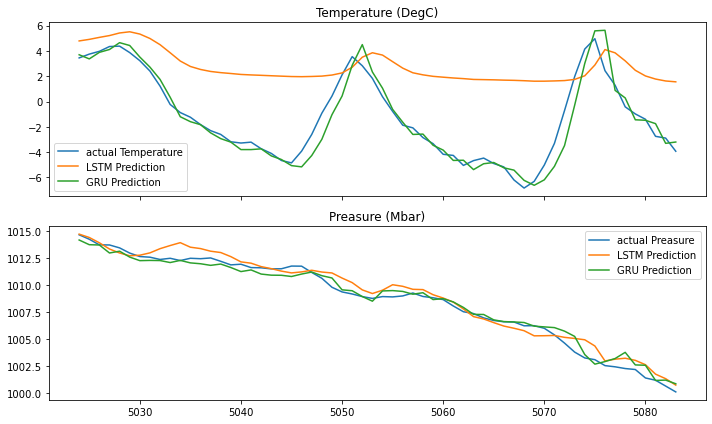

In [91]:
import matplotlib.pyplot as plt

start = 5024
end = 5084

fig,axs = plt.subplots(nrows=2, ncols=1,sharex = True,figsize=(10, 6))
axs = axs.ravel()
axs[1].set_title('Preasure (Mbar)')
axs[1].plot(test_df['actual_0'][start:end],label='actual Preasure')
axs[1].plot(test_df['model_0_predict_0'][start:end],label='LSTM Prediction')
axs[1].plot(test_df['model_1_predict_0'][start:end],label='GRU Prediction')
axs[1].legend()

axs[0].set_title('Temperature (DegC)')
axs[0].plot(test_df['actual_1'][start:end],label='actual Temperature')
axs[0].plot(test_df['model_0_predict_1'][start:end],label='LSTM Prediction')
axs[0].plot(test_df['model_1_predict_1'][start:end],label='GRU Prediction')
axs[0].legend()

fig.tight_layout()

plt.show()

### Summary

Temperature prediction from LSTM seems to be a lot worse compare to the GRU (with same hyperparameter configuration). In this particular, oversimplify, case GRU is better at both accuracy and training time.